In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold  # 데이터를 group 별로 나누고 각 활동(stratified) 비율은 유지 
from sklearn.utils.class_weight import compute_class_weight  # 데이터 불균형할 때 적은 class에 더 큰 weight 제공 
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import random
import os
DATA_PATH = 'C://Users/park9/HAR/WISDM/WISDM_ar_v1.1_raw.txt'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
def seed_everything(seed):
    """
    모든 random seed를 고정하는 함수
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42 
seed_everything(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


In [3]:
EPOCHS = 20
LR = 0.0005
BATCH_SIZE = 64
WINDOW_SIZE = 120
STEP_SIZE = 60
N_FEATURES = 3
N_CLASSES = 6

HYPER_PARAMS = {
    "epochs": EPOCHS,
    "lr": LR
}

In [4]:
def load_data(file_path):
    
    column_names = ['User', 'Activity', 'Timestamp', 'X-axis', 'Y-axis', 'Z-axis']
    df = pd.read_csv(
        file_path,
        header=None,  # 파일의 첫 번째 줄에 column 이름이 없다는 것을 명시 
        names=column_names,
        on_bad_lines='skip',
    )
    df['Z-axis'] = df['Z-axis'].str.replace(';', '').astype(float)
    df['Activity'] = df['Activity'].str.strip()
    print(f'Data loaded successfully. Shape: {df.shape}')
    return df

In [ ]:
def preprocess_data(df):
    # 결측치 제거 
    print(f"NaN 제거 전: {df.isnull().sum().sum()}")
    df = df.dropna()
    print(f"NaN 제거 후: {df.isnull().sum().sum()}")
    
    le = LabelEncoder()
    df['Activity_Encoded'] = le.fit_transform(df['Activity'])
    activity_labels = dict(zip(le.classes_, le.transform(le.classes_)))  # Activity열을 각 정수와 매핑 후 dict형 변환 
    print(f"[Activity: Label]: {activity_labels}")

    scaler = StandardScaler()
    accelerometer_cols = ['X-axis', 'Y-axis', 'Z-axis']
    df[accelerometer_cols] = scaler.fit_transform(df[accelerometer_cols])
    print('전처리 완료')
    return df, le, scaler

In [6]:
def subject_wise_split(df_processed, n_test_users=6):
    
    df = df_processed.copy()
    y = df['Activity_Encoded'].values
    groups = df['User'].values
    users = df['User'].unique()
    n_users = len(users)
    
    if n_test_users >= n_users:
        raise ValueError("Test 수가 전체 User 수를 초과")

    n_splits = int(np.ceil(n_users / n_test_users))  # int(올림(전체 / test)) = 5
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    train_val_idx, test_idx = next(sgkf.split(df, y, groups))
    df_train_val = df.iloc[train_val_idx].copy()
    df_test = df.iloc[test_idx].copy()

    print("--- Train(+Val), Test split 결과 ---")
    print(f"Train/Val Samples: {len(df_train_val)}, Users: {df_train_val['User'].nunique()}")
    print(f"Test Samples: {len(df_test)}, Users: {df_test['User'].nunique()}")
    return df_train_val, df_test

In [7]:
def create_windows(df, window_size, step_size):
    
    X, y = [], []
    for user_id in df['User'].unique():
        user_data = df[df['User'] == user_id]
        accelerometer_data = user_data[['X-axis', 'Y-axis', 'Z-axis']].values
        activity_labels = user_data['Activity_Encoded'].values

        for i in range(0, len(accelerometer_data) - window_size + 1, step_size):
            window = accelerometer_data[i: i + window_size]
            X.append(window)
            
            window_labels = activity_labels[i: i + window_size]
            modal_label = np.bincount(window_labels).argmax()
            y.append(modal_label)
    return np.array(X), np.array(y)

In [8]:
class HAR_Dataset(Dataset):

    def __init__(self, X_data, y_data):
        X_data_reshaped = X_data.transpose(0, 2, 1)
        self.X_data = torch.tensor(X_data_reshaped, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [9]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_features=N_FEATURES, hidden_size=512, num_layers=1, n_classes=N_CLASSES):
        super().__init__()

        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(n_features, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        self.dropout = nn.Dropout(0.6)
        self.classifier = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.cnn_extractor(x)
        x = x.permute(0, 2, 1)
        # h0, c0 생략
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = self.dropout(out)
        out = self.classifier(out)
        return out

In [10]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += residual
        out = self.relu(out)

        return out
    
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, seq_output):
        energy = torch.tanh(self.attn(seq_output))
        attn_scores = torch.einsum('bij,j->bi', energy, self.v)
        attention_weights = self.softmax(attn_scores)
        context_vector = torch.einsum('bi,bij->bj', attention_weights, seq_output)
        return context_vector, attention_weights
    
class ResNet_Attention(nn.Module):
    def __init__(self, n_features=N_FEATURES, n_classes=N_CLASSES):
        super().__init__()

        self.initial_conv = nn.Conv1d(n_features, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualBlock1D(64, 64)
        self.layer2 = ResidualBlock1D(64, 128, stride=2) # stride=2로 시퀀스 길이를 줄임
        self.layer3 = ResidualBlock1D(128, 256, stride=2)

        self.attention = Attention(256)

        self.classifier = nn.Linear(256, n_classes)

    def forward(self, x):
        # 1. 초기 Conv + Pooling
        # Input shape: (B, 3, 80)
        x = self.maxpool(self.relu(self.initial_bn(self.initial_conv(x))))
        
        # 2. ResNet Blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) # shape: (B, 256, Seq_len_reduced)
        
        # 3. Attention을 위한 차원 변경 (채널을 마지막 차원으로)
        x = x.permute(0, 2, 1) # shape: (B, Seq_len_reduced, 256)
        
        # 4. Attention 적용
        context_vector, _ = self.attention(x) # shape: (B, 256)
        
        # 5. 최종 분류
        output = self.classifier(context_vector)
        return output


In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, criterion, device):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
    return model, history

def evaluate_model(model, data_loader, criterion, device):

    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

def predict_ensemble(models, data_loader, device):

    all_probabilities = []  # 모든 모델의 예측 확률 저장 
    all_labels = []

    with torch.no_grad():
        for model in models:
            model.eval()
            model_probabilities = []

            # 첫 번째 루프에서만 실제 라벨을 가져옴 (모든 루프에서 동일하므로)
            if not all_labels:
                is_first_loop = True
            else:
                is_first_loop = False

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                outputs  = model(inputs)

                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                model_probabilities.extend(probabilities)

                if is_first_loop:
                    all_labels.extend(labels.numpy())

            all_probabilities.append(model_probabilities)
    
    # 모델들의 예측 확률을 평균냄
    # (n_models, n_samples, n_classes) -> (n_samples, n_classes)
    avg_probabilities = np.mean(all_probabilities, axis=0)

    # 평균 확률이 가장 높은 클래스를 최종 예측으로 선택
    final_predictions = np.argmax(avg_probabilities, axis=1)

    return final_predictions, np.array(all_labels)

In [12]:
def run_cv_on_train_val(df_train_val, ModelClass, hyper_params, n_splits=5):
    
    all_val_accs = []
    models_from_cv = []  # 학습된 각 CV 모델을 저장할 리스트

    y_tv, groups_tv = df_train_val['Activity_Encoded'].values, df_train_val['User'].values
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(np.arange(len(df_train_val)), y_tv, groups=groups_tv)):
        print(f"\n======== Starting CV Fold {fold+1}/{n_splits} ({ModelClass.__name__}) ========")
        df_train_fold, df_val_fold = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]

        X_train, y_train = create_windows(df_train_fold, WINDOW_SIZE, STEP_SIZE)
        X_val, y_val = create_windows(df_val_fold, WINDOW_SIZE, STEP_SIZE)
        
        train_dataset = HAR_Dataset(X_train, y_train)
        val_dataset = HAR_Dataset(X_val, y_val)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        weighted_criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(DEVICE))
        
        model = ModelClass().to(DEVICE)

        trained_model, history = train_model(model, train_loader, val_loader, 
                                 epochs=hyper_params["epochs"], lr=hyper_params["lr"], 
                                 criterion=weighted_criterion, device=DEVICE)
        
        models_from_cv.append(trained_model)  # 학슨된 모델들 저장 
        
        final_val_acc = history['val_acc'][-1]
        all_val_accs.append(final_val_acc)
        print(f"Fold {fold+1} Final Validation Accuracy: {final_val_acc:.4f}")

    mean_acc, std_acc = np.mean(all_val_accs), np.std(all_val_accs)
    print(f"\n--- CV Result for {ModelClass.__name__}: 평균 Acc = {mean_acc:.4f} (+/- {std_acc:.4f}) ---")
    
    return models_from_cv

Data loaded successfully. Shape: (1086466, 6)
NaN 제거 전: 1
NaN 제거 후: 0


C:\Users\park9\AppData\Local\Temp\ipykernel_16432\269409863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Activity_Encoded'] = le.fit_transform(df['Activity'])
C:\Users\park9\AppData\Local\Temp\ipykernel_16432\269409863.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[accelerometer_cols] = scaler.fit_transform(df[accelerometer_cols])


[Activity: Label]: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
전처리 완료
--- Train(+Val), Test split 결과 ---
Train/Val Samples: 969204, Users: 31
Test Samples: 117261, Users: 5

--- Starting 5-Fold CV to generate ensemble models for ResNet_Attention ---

======== Starting CV Fold 1/5 (ResNet_Attention) ========
Epoch 1/20 - Train Loss: 0.4610, Train Acc: 0.8532 | Val Loss: 0.2221, Val Acc: 0.9290
Epoch 2/20 - Train Loss: 0.2396, Train Acc: 0.9346 | Val Loss: 0.2320, Val Acc: 0.9296
Epoch 3/20 - Train Loss: 0.1975, Train Acc: 0.9523 | Val Loss: 0.2304, Val Acc: 0.9357
Epoch 4/20 - Train Loss: 0.1613, Train Acc: 0.9615 | Val Loss: 0.2548, Val Acc: 0.9408
Epoch 5/20 - Train Loss: 0.1392, Train Acc: 0.9707 | Val Loss: 0.2731, Val Acc: 0.9388
Epoch 6/20 - Train Loss: 0.1172, Train Acc: 0.9727 | Val Loss: 0.2887, Val Acc: 0.9330
Epoch 7/20 - Train Loss: 0.1188, Train Acc: 0.9719 | Val Loss: 0.2414, Val Acc: 0.9310
Epoch 8/20 - Train Loss: 0.0868, Tra

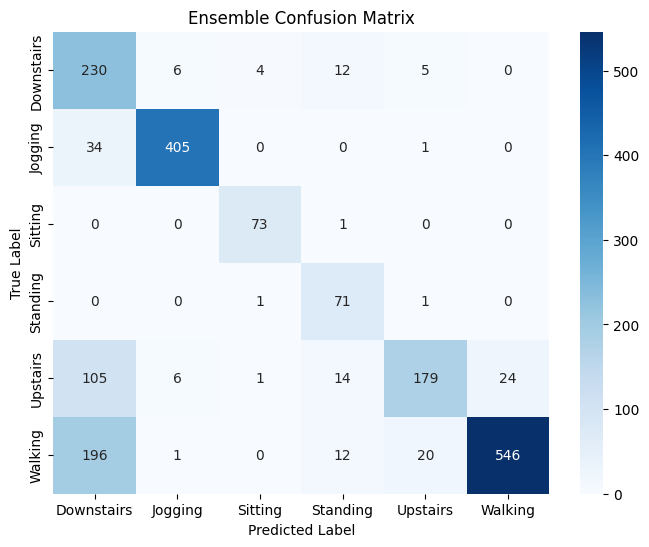

In [15]:
if __name__ == '__main__':
    # 데이터 준비
    df_raw = load_data(DATA_PATH)
    df_processed, label_encoder, scaler = preprocess_data(df_raw)
    class_names = list(label_encoder.classes_)
    df_train_val, df_test = subject_wise_split(df_processed, n_test_users=6)

    # CV를 실행하여 앙상블할 모델 5개 얻기
    print(f"\n--- Starting 5-Fold CV to generate ensemble models for {ResNet_Attention.__name__} ---")
    
    # 5개의 학습된 모델을 얻기
    cv_models = run_cv_on_train_val(df_train_val, ResNet_Attention, HYPER_PARAMS)
    
    # 앙상블 모델로 Test Set 예측
    print("\n--- Predicting on Test Set using Ensemble Model ---")
    
    # Test Set을 위한 데이터로더 생성
    X_test, y_test = create_windows(df_test, WINDOW_SIZE, STEP_SIZE)
    test_dataset = HAR_Dataset(X_test, y_test)
    final_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 앙상블 예측 함수 호출
    y_pred, y_true = predict_ensemble(cv_models, final_test_loader, DEVICE)
    
    # 최종 결과 출력 
    print(f"\n================ Final Test Set Evaluation: Ensemble of {len(cv_models)} {ResNet_Attention.__name__} models ================")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Ensemble Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()